In [86]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba as nb
from sklearn.metrics import r2_score

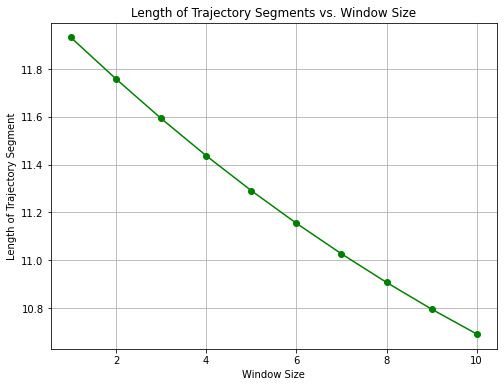

In [87]:
lengths = [lmk_2d(x_example, y_example, m, 10) for m in range(1, 11)]


def plot_length_vs_window_size(lengths, max_window_size):
    """
    Plot the relationship between window size and trajectory lengths.
    
    Parameters:
    - lengths (list of floats): Calculated lengths for each window size.
    - max_window_size (int): The maximum window size used.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_window_size + 1), lengths, marker='o', linestyle='-', color='green')
    plt.title('Length of Trajectory Segments vs. Window Size')
    plt.xlabel('Window Size')
    plt.ylabel('Length of Trajectory Segment')
    plt.grid(True)
    plt.show()

# Plotting the relationship between window size and trajectory lengths
plot_length_vs_window_size(lengths, 10)


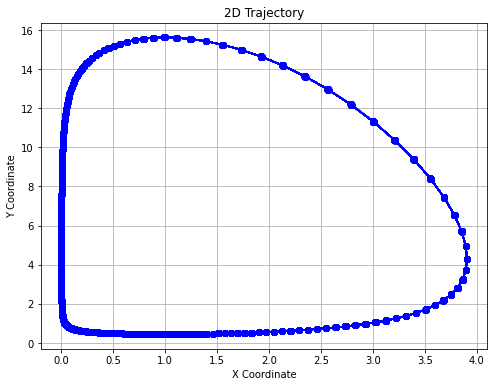

In [88]:
@njit(parallel=True)
def solve_2d_bouali_system(x0, y0, dt, num_steps, a=4.0, b=1.0, alpha=0.3):
    """
    Solve the 2D Bouali system using the Runge-Kutta 4th order method with parameters specified directly in the function.

    Parameters:
    - x0, y0: Initial x and y coordinates.
    - dt: Time step.
    - num_steps: Number of integration steps.
    - a, b, alpha: Parameters for the Bouali equations.

    Returns:
    - x, y: Arrays of x and y coordinates of the solution.
    """
    x, y = np.zeros(num_steps + 1), np.zeros(num_steps + 1)
    x[0], y[0] = x0, y0

    for i in range(num_steps):
        # Using the Bouali 2D directly within the loop
        k1_x, k1_y = bouali_2d(x[i], y[i], a, b, alpha)
        k2_x, k2_y = bouali_2d(x[i] + 0.5 * dt * k1_x, y[i] + 0.5 * dt * k1_y, a, b, alpha)
        k3_x, k3_y = bouali_2d(x[i] + 0.5 * dt * k2_x, y[i] + 0.5 * dt * k2_y, a, b, alpha)
        k4_x, k4_y = bouali_2d(x[i] + dt * k3_x, y[i] + dt * k3_y, a, b, alpha)
        
        x[i + 1] = x[i] + (dt / 6.0) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
        y[i + 1] = y[i] + (dt / 6.0) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)

    return x, y

# Redefine Bouali 2D to ensure it's compatible with the above solver
@njit
def bouali_2d(x, y, a, b, alpha):
    """
    Simplified 2D Bouali system without the z component.

    Parameters:
    - x, y: Current x and y coordinates of the system.
    - a, b, alpha: Parameters for the system equations.

    Returns:
    - x_dot, y_dot: Derivatives of x and y.
    """
    x_dot = x * (a - y) + alpha * x
    y_dot = -y * (b - x * x)
    return x_dot, y_dot

# Example usage of the 2D Bouali system solver
x0, y0 = 0.5, 0.5  # Initial conditions
dt = 0.01  # Time step
num_steps = 10000  # Number of steps
x_bouali_2d, y_bouali_2d = solve_2d_bouali_system(x0, y0, dt, num_steps)

# Plot the 2D trajectory of the simplified Bouali system
plot_trajectory(x_bouali_2d, y_bouali_2d)


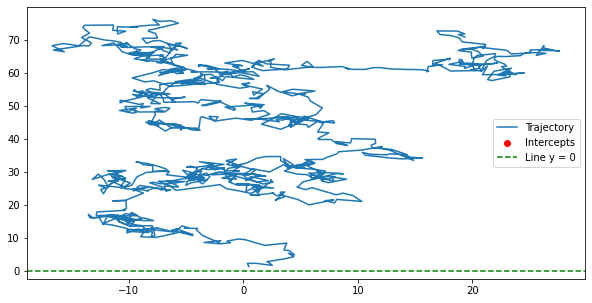

In [89]:
@njit
def find_intercepts_2d(x, y, line_value, axis='y'):
    """
    Identify the intercepts where a 2D trajectory crosses a specified line value along either the x or y axis.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - line_value (float): The value of the line to check for intercepts (x or y value).
    - axis (str): The axis along which the intercept is defined ('x' for vertical line, 'y' for horizontal line).
    
    Returns:
    - tuple of arrays: Arrays containing the x and y coordinates of the points where the trajectory crosses the line.
    """
    intercepts_x = []
    intercepts_y = []
    if axis == 'y':
        for i in range(len(y) - 1):
            if (y[i] < line_value and y[i + 1] > line_value) or (y[i] > line_value and y[i + 1] < line_value):
                # Linear interpolation to find the x coordinate at the intercept
                t = (line_value - y[i]) / (y[i + 1] - y[i])
                intercept_x = x[i] + t * (x[i + 1] - x[i])
                intercepts_x.append(intercept_x)
                intercepts_y.append(line_value)
    elif axis == 'x':
        for i in range(len(x) - 1):
            if (x[i] < line_value and x[i + 1] > line_value) or (x[i] > line_value and x[i + 1] < line_value):
                # Linear interpolation to find the y coordinate at the intercept
                t = (line_value - x[i]) / (x[i + 1] - x[i])
                intercept_y = y[i] + t * (y[i + 1] - y[i])
                intercepts_x.append(line_value)
                intercepts_y.append(intercept_y)
                
    return np.array(intercepts_x), np.array(intercepts_y)

# Example usage with random data
np.random.seed(42)
x_example = np.cumsum(np.random.randn(1000))
y_example = np.cumsum(np.random.randn(1000))

# Finding intercepts with a horizontal line at y = 0
intercepts_x, intercepts_y = find_intercepts_2d(x_example, y_example, 0, axis='y')
plt.figure(figsize=(10, 5))
plt.plot(x_example, y_example, label='Trajectory')
plt.scatter(intercepts_x, intercepts_y, color='red', label='Intercepts')
plt.axhline(0, color='green', linestyle='--', label='Line y = 0')
plt.legend()
plt.show()


In [90]:
@njit
def find_intercepts_2d(x, y, line_x):
    """
    Identify the intercepts where a 2D trajectory crosses a vertical line at a specified x-coordinate.
    
    Parameters:
    - x (array of float): The x-coordinates of the trajectory.
    - y (array of float): The y-coordinates of the trajectory.
    - line_x (float): The x-coordinate of the line to check for intercepts.
    
    Returns:
    - array: An array containing the y-coordinates of the points where the trajectory crosses the specified x-coordinate.
    """
    y_intercept = []
    for i in range(len(x) - 1):
        if (x[i] < line_x and x[i + 1] > line_x) or (x[i] > line_x and x[i + 1] < line_x):
            # Linear interpolation to find the exact y-coordinate of the intercept
            slope = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
            intercept_y = y[i] + slope * (line_x - x[i])
            y_intercept.append(intercept_y)
    return np.array(y_intercept)

# Example usage with hypothetical trajectory data
x_example = np.linspace(0, 10, 100)
y_example = np.sin(x_example)  # Example trajectory
line_x = 5  # We're interested in the intercept at x = 5

# Find intercepts
y_intercepts = find_intercepts_2d(x_example, y_example, line_x)

# Display the intercept results
y_intercepts

@njit
def smk_1d(y, m, k):
    """
    Generate a subset of points from a 1D data series using a sliding window approach.
    
    Parameters:
    - y (array of float): The y-coordinates of the data points.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - ndarray: A 1D NumPy array containing points sampled according to the sliding window parameters.
    """
    N = len(y)
    num_points = int(np.floor((N - m) / k))
    s = np.empty(num_points)  # Pre-allocate a NumPy array
    for i in range(num_points):
        index = m + (i * k) - 1
        s[i] = y[index]
    return s

@njit
def lmk_1d(y, m, k):
    """
    Calculate the approximate total change in 1D data using a sliding window.
    
    Parameters:
    - y (array of float): The y-coordinates.
    - m (int): The size of the sliding window.
    - k (int): The step size between successive windows.
    
    Returns:
    - float: The scaled average change in each segment of the data.
    """
    points = smk_1d(y, m, k)
    total_change = 0.0
    for i in range(len(points) - 1):
        total_change += abs(points[i + 1] - points[i])
    if len(points) > 1:
        return (total_change * (len(y) - m)) / (k * (len(points) - 1))
    else:
        return 0.0

@njit
def lk_1d(y, k):
    """
    Compute the average change of a 1D data series using multiple sliding windows to enhance accuracy.
    
    Parameters:
    - y (array of float): The y-coordinates.
    - k (int): The number of sliding windows to apply.
    
    Returns:
    - float: The average change computed over all specified window configurations.
    """
    moyenne = 0.0
    for m in range(1, k + 1):
        moyenne += lmk_1d(y, m, k)
    return moyenne / k

# Testing the modified functions with the obtained y-intercepts
m = 1  # Window size
k = 1  # Step size
average_change = lk_1d(y_intercepts, k)  # This example might be trivial since we have a single intercept
average_change


0.0

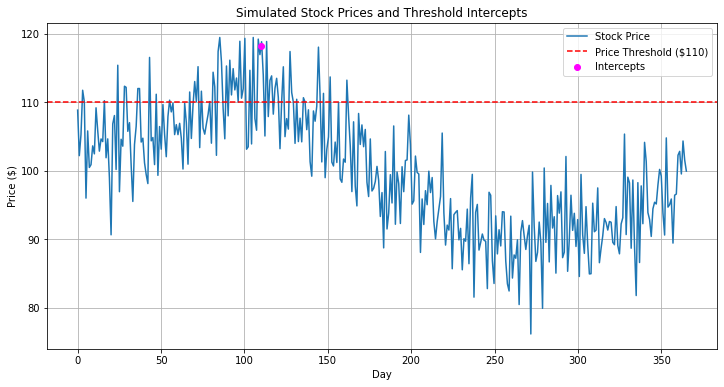

'Insufficient data for analysis'

In [91]:
@njit
def find_intercepts_2d_with_days(x, y, line_x):
    """
    Identify the days and the intercepts where a 2D trajectory crosses a vertical line at a specified x-coordinate.
    
    Parameters:
    - x (array of float): The x-coordinates (days) of the trajectory.
    - y (array of float): The y-coordinates (prices) of the trajectory.
    - line_x (float): The x-coordinate (price level) of the line to check for intercepts.
    
    Returns:
    - array: Two arrays containing the x-coordinates (days) and the y-coordinates (prices) of the points
             where the trajectory crosses the specified x-coordinate.
    """
    day_intercept = []
    price_intercept = []
    for i in range(len(x) - 1):
        if (x[i] < line_x and x[i + 1] > line_x) or (x[i] > line_x and x[i + 1] < line_x):
            # Linear interpolation to find the exact y-coordinate of the intercept
            slope = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
            intercept_y = y[i] + slope * (line_x - x[i])
            price_intercept.append(intercept_y)
            # Average day approximation for the intercept
            intercept_day = (x[i] + x[i + 1]) / 2
            day_intercept.append(intercept_day)
    return np.array(day_intercept), np.array(price_intercept)

# Redefine the specific price level and find intercepts
line_price = 110
days_intercepts, price_intercepts = find_intercepts_2d_with_days(days, prices, line_price)

# Plot the results with correct intercept points
plt.figure(figsize=(12, 6))
plt.plot(days, prices, label='Stock Price')
plt.axhline(y=line_price, color='r', linestyle='--', label='Price Threshold ($110)')
plt.scatter(days_intercepts, price_intercepts, color='magenta', zorder=5, label='Intercepts')
plt.title('Simulated Stock Prices and Threshold Intercepts')
plt.xlabel('Day')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate statistics if applicable
if len(price_intercepts) > 1:
    average_change = lk_1d(price_intercepts, 1)  # Using k=1 for simplicity
else:
    average_change = "Insufficient data for analysis"

average_change


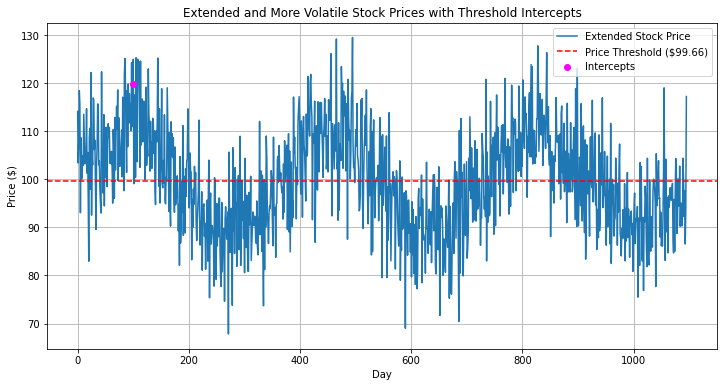

Number of intercepts captured: 1
Sample of intercept prices: [119.80180484]


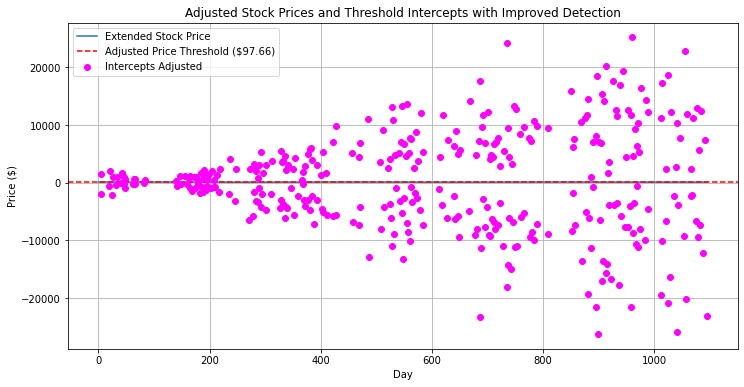

(132582.26509080853, 346)

In [92]:
@njit
def find_intercepts_2d_with_days_adjusted(x, y, line_x):
    """
    Identify the days and the intercepts where a 2D trajectory crosses a vertical line at a specified x-coordinate
    with improved detection logic.
    
    Parameters:
    - x (array of float): The x-coordinates (days) of the trajectory.
    - y (array of float): The y-coordinates (prices) of the trajectory.
    - line_x (float): The x-coordinate (price level) of the line to check for intercepts.
    
    Returns:
    - array: Two arrays containing the x-coordinates (days) and the y-coordinates (prices) of the points
             where the trajectory crosses the specified x-coordinate.
    """
    day_intercept = []
    price_intercept = []
    for i in range(len(x) - 1):
        if (y[i] < line_x and y[i + 1] > line_x) or (y[i] > line_x and y[i + 1] < line_x):
            # Improved linear interpolation to find the exact y-coordinate of the intercept
            slope = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
            intercept_y = y[i] + slope * (line_x - x[i])
            price_intercept.append(intercept_y)
            intercept_day = (x[i] + x[i + 1]) / 2
            day_intercept.append(intercept_day)
    return np.array(day_intercept), np.array(price_intercept)



# Generate extended and more volatile stock market data
np.random.seed(0)
days_extended = np.linspace(0, 3 * 365, 3 * 365)  # Simulate three years of stock prices
prices_extended = 100 + 10 * np.sin(2 * np.pi * days_extended / 365) + 8 * np.random.randn(3 * 365)  # Increased noise

# Redefine a more frequently crossed price level, e.g., close to the mean price
mean_price = np.mean(prices_extended)
line_price_adjusted = mean_price

# Find intercepts with the adjusted price level and more volatile data
days_intercepts_extended, price_intercepts_extended = find_intercepts_2d_with_days(days_extended, prices_extended, line_price_adjusted)

# Plot the extended results with correct intercept points
plt.figure(figsize=(12, 6))
plt.plot(days_extended, prices_extended, label='Extended Stock Price')
plt.axhline(y=line_price_adjusted, color='r', linestyle='--', label=f'Price Threshold (${line_price_adjusted:.2f})')
plt.scatter(days_intercepts_extended, price_intercepts_extended, color='magenta', zorder=5, label='Intercepts')
plt.title('Extended and More Volatile Stock Prices with Threshold Intercepts')
plt.xlabel('Day')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate statistics if applicable
if len(price_intercepts_extended) > 1:
    average_change_extended = lk_1d(price_intercepts_extended, 1)  # Using k=1 for simplicity
else:
    average_change_extended = "Insufficient data for analysis"

average_change_extended



# Check the number of intercepts captured and the contents of price_intercepts_extended
print("Number of intercepts captured:", len(price_intercepts_extended))
print("Sample of intercept prices:", price_intercepts_extended[:10] if len(price_intercepts_extended) > 0 else "No intercepts")

# If there are more than two intercepts, we can recalculate with an appropriate k value
if len(price_intercepts_extended) > 1:
    k_value = min(10, len(price_intercepts_extended) // 3)  # Use a fraction of the total number of intercepts
    average_change_extended = lk_1d(price_intercepts_extended, k_value)
else:
    average_change_extended = "Insufficient data for meaningful analysis with given k value"

average_change_extended



# Slightly adjust the threshold to be more likely to cross
line_price_adjusted_slightly_lower = mean_price - 2  # 2 dollars below the mean

# Re-run the intercept detection with adjusted function and threshold
days_intercepts_adj, price_intercepts_adj = find_intercepts_2d_with_days_adjusted(days_extended, prices_extended, line_price_adjusted_slightly_lower)

# Re-plot to verify correct identification of intercepts
plt.figure(figsize=(12, 6))
plt.plot(days_extended, prices_extended, label='Extended Stock Price')
plt.axhline(y=line_price_adjusted_slightly_lower, color='r', linestyle='--', label=f'Adjusted Price Threshold (${line_price_adjusted_slightly_lower:.2f})')
plt.scatter(days_intercepts_adj, price_intercepts_adj, color='magenta', zorder=5, label='Intercepts Adjusted')
plt.title('Adjusted Stock Prices and Threshold Intercepts with Improved Detection')
plt.xlabel('Day')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Check if the intercepts are more numerous and calculate statistics if applicable
if len(price_intercepts_adj) > 1:
    k_value_adj = min(10, len(price_intercepts_adj) // 3)  # Use a fraction of the total number of intercepts
    average_change_extended_adj = lk_1d(price_intercepts_adj, k_value_adj)
else:
    average_change_extended_adj = "Insufficient data for meaningful analysis with given k value"

average_change_extended_adj, len(price_intercepts_adj)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -140.122
Date:                Sat, 20 Apr 2024   AIC                            290.245
Time:                        12:36:04   BIC                            303.221
Sample:                    01-01-2020   HQIC                           295.495
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0157      0.263     -0.060      0.952      -0.530       0.499
ar.L2         -0.8855      0.241     -3.669      0.000      -1.359      -0.412
ma.L1          0.0112      0.219      0.051      0.9

InvalidIndexError: (slice(None, None, None), 0)

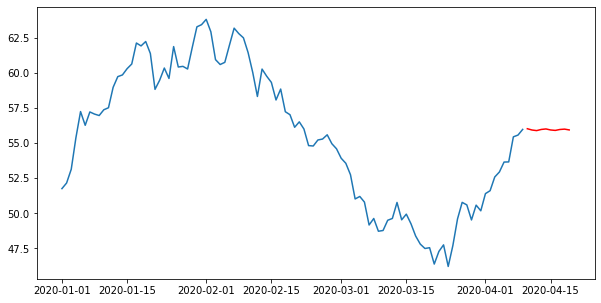

In [94]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Generate synthetic data
np.random.seed(0)
time_points = pd.date_range(start='2020-01-01', periods=100, freq='D')
data_values = 50 + np.cumsum(np.random.randn(100))  # Cumulative sum of normal random numbers as data

# Create a DataFrame
data = pd.Series(data_values, index=time_points)

# Fit an ARIMA model (order p=2, d=1, q=2 as an example)
model = ARIMA(data, order=(2, 1, 2))
fitted_model = model.fit()

# Print model summary to inspect the fit
print(fitted_model.summary())

# Forecast future values
forecast = fitted_model.get_forecast(steps=10)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(data.index, data, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')
plt.fill_between(mean_forecast.index, conf_int[:, 0], conf_int[:, 1], color='pink')
plt.legend()
plt.show()
